In [1]:
import sys
import os
copypath = ['../modules', 
            '../Train', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python27.zip', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/plat-linux2', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-tk', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-old', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-dynload', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages', 
            '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg']
for p in reversed(copypath):
    sys.path.insert(0, p)
print sys.path
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['DEEPJET'] = '../../DeepJet'
#os.environ['LD_LIBRARY_PATH'] = '../modules:%s'%os.environ['LD_LIBRARY_PATH']
#os.environ['PATH'] = '../scripts:%s'%os.environ['PATH']
#os.environ['CONDA_PREFIX'] = '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu'
#os.environ['LD_PRELOAD'] = '%s/lib/libmkl_core.so:%s/lib/libmkl_sequential.so'%(os.environ['CONDA_PREFIX'],os.environ['CONDA_PREFIX'])
import keras
keras.backend.set_image_data_format('channels_first')

['../modules', '../Train', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python27.zip', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/plat-linux2', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-tk', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-old', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/lib-dynload', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages', '/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '', '/opt/conda/envs/python2/lib/python27.zip', '/opt/conda/envs/python2/lib/python2.7', '/opt/conda/envs/python2/lib/python2.7/plat-linux2', '/opt/conda/envs/python2/lib/python2.7/li

Using TensorFlow backend.


In [2]:
!nvidia-smi

Mon Sep  4 13:11:49 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |   7591MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |   7781MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
from keras.models import load_model, Model
from testing import testDescriptor
from argparse import ArgumentParser
from keras import backend as K
from Losses import * #needed!
import os
import numpy as np
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from root_numpy import array2root
import pandas as pd


In [4]:
def makeRoc(testd, model, outputDir):
    ## # summarize history for loss for training and test sample
    ## plt.figure(1)
    ## plt.plot(callbacks.history.history['loss'])
    ## plt.plot(callbacks.history.history['val_loss'])
    ## plt.title('model loss')
    ## plt.ylabel('loss')
    ## plt.xlabel('epoch')
    ## plt.legend(['train', 'test'], loc='upper left')
    ## plt.savefig(self.outputDir+'learningcurve.pdf') 
    ## plt.close(1)

    ## plt.figure(2)
    ## plt.plot(callbacks.history.history['acc'])
    ## plt.plot(callbacks.history.history['val_acc'])
    ## plt.title('model accuracy')
    ## plt.ylabel('acc')
    ## plt.xlabel('epoch')
    ## plt.legend(['train', 'test'], loc='upper left')
    ## plt.savefig(self.outputDir+'accuracycurve.pdf')
    ## plt.close(2)

    print 'in makeRoc()'
    
    # let's use only first 10000000 entries
    NENT = 10000000
    features_val = [fval[:NENT] for fval in testd.getAllFeatures()]
    labels_val=testd.getAllLabels()[0][:NENT,:]
    weights_val=testd.getAllWeights()[0][:NENT]
    spectators_val = testd.getAllSpectators()[0][:NENT,0,:]
    print features_val[0].shape
    df = pd.DataFrame(spectators_val)
    df.columns = ['fj_pt',
                  'fj_eta',
                  'fj_sdmass',
                  'fj_n_sdsubjets',
                  'fj_doubleb',
                  'fj_tau21',
                  'fj_tau32',
                  'npv',
                  'npfcands',
                  'ntracks',
                  'nsv']

    print(df.iloc[:10])

        
    predict_test = model.predict(features_val)
    df['fj_isH'] = labels_val[:,1]
    df['fj_deepdoubleb'] = predict_test[:,1]

    print(df.iloc[:10])

    fpr, tpr, threshold = roc_curve(df['fj_isH'],df['fj_deepdoubleb'])
    dfpr, dtpr, threshold1 = roc_curve(df['fj_isH'],df['fj_doubleb'])

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx, array[idx]

    value = 0.01 # 1% mistag rate
    idx, val = find_nearest(fpr, value)
    deepdoublebcut = threshold[idx] # threshold for deep double-b corresponding to ~1% mistag rate
    print('deep double-b > %f coresponds to %f%% QCD mistag rate'%(deepdoublebcut,100*val))

    auc1 = auc(fpr, tpr)
    auc2 = auc(dfpr, dtpr)

    plt.figure()       
    plt.plot(tpr,fpr,label='deep double-b, auc = %.1f%%'%(auc1*100))
    plt.plot(dtpr,dfpr,label='BDT double-b, auc = %.1f%%'%(auc2*100))
    plt.semilogy()
    plt.xlabel("H(bb) efficiency")
    plt.ylabel("QCD mistag rate")
    plt.ylim(0.001,1)
    plt.grid(True)
    plt.legend()
    plt.savefig(outputDir+"test.pdf")
    
    plt.figure()
    bins = np.linspace(-1,1,70)
    plt.hist(df['fj_doubleb'], bins=bins, weights = 1-df['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df['fj_doubleb'], bins=bins, weights = df['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel("BDT double-b")
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"doubleb.pdf")
    
    plt.figure()
    bins = np.linspace(0,1,70)
    plt.hist(df['fj_deepdoubleb'], bins=bins, weights = 1-df['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df['fj_deepdoubleb'], bins=bins, weights = df['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel("deep double-b")
    #plt.ylim(0.00001,1)
    #plt.semilogy()
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"deepdoubleb.pdf")
    
    plt.figure()
    bins = np.linspace(0,2000,70)
    plt.hist(df['fj_pt'], bins=bins, weights = 1-df['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df['fj_pt'], bins=bins, weights = df['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel(r'$p_{\mathrm{T}}$')
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"pt.pdf")
    
    plt.figure()
    bins = np.linspace(0,200,70)
    plt.hist(df['fj_sdmass'], bins=bins, weights = 1-df['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df['fj_sdmass'], bins=bins, weights = df['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel(r'$m_{\mathrm{SD}}$')
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"msd.pdf")
    
    plt.figure()
    bins = np.linspace(0,200,70)
    df_passdoubleb = df[df.fj_doubleb > 0.9]
    plt.hist(df_passdoubleb['fj_sdmass'], bins=bins, weights = 1-df_passdoubleb['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df_passdoubleb['fj_sdmass'], bins=bins, weights = df_passdoubleb['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel(r'$m_{\mathrm{SD}}$')
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"msd_passdoubleb.pdf")
    
    plt.figure()
    bins = np.linspace(0,200,70)
    df_passdeepdoubleb = df[df.fj_deepdoubleb > deepdoublebcut]
    plt.hist(df_passdeepdoubleb['fj_sdmass'], bins=bins, weights = 1-df_passdeepdoubleb['fj_isH'],alpha=0.5,normed=True,label='QCD')
    plt.hist(df_passdeepdoubleb['fj_sdmass'], bins=bins, weights = df_passdeepdoubleb['fj_isH'],alpha=0.5,normed=True,label='H(bb)')
    plt.xlabel(r'$m_{\mathrm{SD}}$')
    plt.legend(loc='upper left')
    plt.savefig(outputDir+"msd_passdeepdoubleb.pdf")
    
    return df

In [5]:
!rm -r out_deepsimple

/inputdata/BumbleB/jduarte/miniconda2/envs/deepjetLinux3_gpu/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


in makeRoc()
(7400957, 1, 27)
         fj_pt    fj_eta   fj_sdmass  fj_n_sdsubjets  fj_doubleb  fj_tau21  \
0  1341.753906 -0.857475   31.955616             2.0   -0.338851  0.574746   
1  1199.216431  0.672301  184.797302             2.0    0.345067  0.597914   
2  1198.793457  0.374637    7.449878             2.0   -0.271641  0.871469   
3  1008.766174  0.051419  208.817795             2.0   -0.737059  0.481590   
4  1217.592773 -0.273299    9.561430             2.0   -0.867258  0.825349   
5  1177.484009 -0.108096   52.555882             2.0   -0.877467  0.780244   
6  1038.037109  0.849492   16.399689             2.0   -0.750770  0.711005   
7   994.958618  0.011310    9.822352             2.0   -0.557818  0.640318   
8  1261.527100 -0.128758   11.176943             2.0   -0.852823  0.663784   
9  1183.607300 -0.916067   11.959915             2.0    0.070836  0.670363   

   fj_tau32   npv  npfcands  ntracks  nsv  
0  0.830599  12.0      39.0     24.0  1.0  
1  0.405185  12.0      

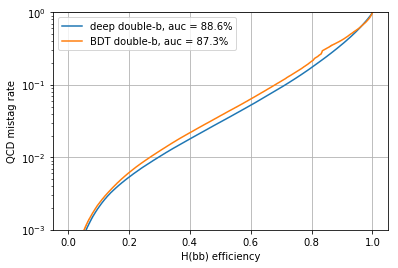

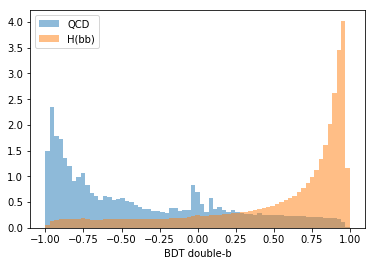

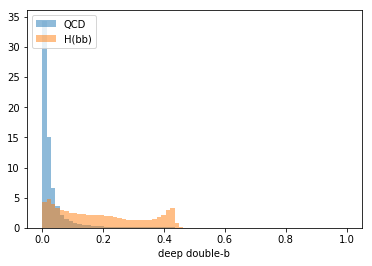

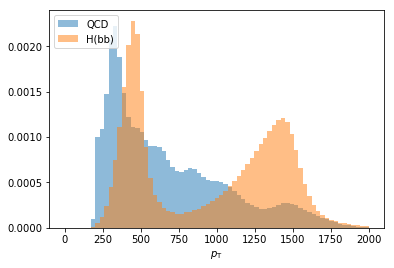

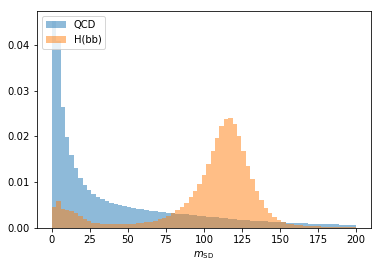

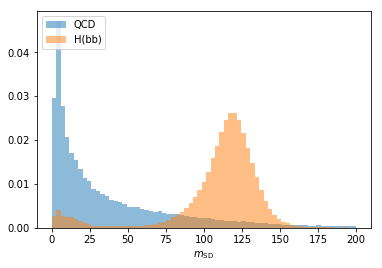

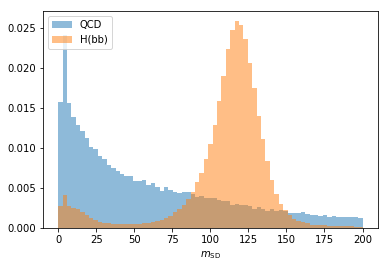

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

inputModel = 'train_deepsimple/KERAS_check_best_model.h5'
#inputModel = 'train_deepsimple/KERAS_check_model_last.h5'
outputDir = 'out_deepsimple/'
# test data:
inputDataCollection = '/inputdata/BumbleB/convert_deepDoubleB_simple_test/dataCollection.dc'
# training data:
#inputDataCollection = '/inputdata/BumbleB/convert_deepDoubleB_simple_train_val/dataCollection.dc'

if os.path.isdir(outputDir):
    raise Exception('output directory must not exists yet')
else: 
    os.mkdir(outputDir)

model=load_model(inputModel, custom_objects=global_loss_list)
    

#intermediate_output = intermediate_layer_model.predict(data)

#print(model.summary())
    
from DataCollection import DataCollection
    
testd=DataCollection()
testd.readFromFile(inputDataCollection)
    
df = makeRoc(testd, model, outputDir)

In [7]:
# let's use only first 10000000 entries
NENT = 10000000
features_val = [fval[:NENT] for fval in testd.getAllFeatures()]

In [8]:
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 27)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 27)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
__________

In [9]:
inputModel = 'train_deepsimple/KERAS_check_model_last.h5'
model=load_model(inputModel, custom_objects=global_loss_list)

layer_name = 'flatten_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
print 'flatten_1', intermediate_layer_model.predict(features_val)

layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
print 'dense_1', intermediate_layer_model.predict(features_val)

flatten_1 [[-0.86557847 -0.96746707 -1.22574246 ..., -0.32146591 -0.12977178
  -0.51232445]
 [ 0.51103938 -0.04881356  0.36578774 ...,  0.31560421  0.40646917
   0.09711127]
 [-0.2537483   0.86983991  0.25720766 ..., -0.08359075  0.08995759
  -0.10513402]
 ..., 
 [-0.2537483  -0.04881356  0.91949886 ...,  0.74945569  0.28063363
  -0.13715857]
 [-1.63036609 -0.04881356  1.35701787 ..., -0.55507392 -0.26741529
   1.70365405]
 [-1.01853597 -0.96746707 -1.22574246 ..., -0.10068057  0.09582865
  -0.51232445]]
dense_1 [[ 0.          0.          0.58365172 ...,  0.21312505  1.05804193
   0.13989699]
 [ 0.          0.          0.         ...,  0.          0.          0.22331116]
 [ 0.          0.          0.         ...,  0.43069986  0.1924116   0.        ]
 ..., 
 [ 0.          0.414819    0.         ...,  0.67112029  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.04075095
   0.79815799]
 [ 0.          0.          0.59145981 ...,  0.41113499  1.22266519
   0

In [10]:
inputModel = 'train_deepsimple/KERAS_check_best_model.h5'
model=load_model(inputModel, custom_objects=global_loss_list)

layer_name = 'flatten_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
print 'flatten_1', intermediate_layer_model.predict(features_val)

layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
print 'dense_1', intermediate_layer_model.predict(features_val)

flatten_1 [[-0.86557847 -0.96746707 -1.22574246 ..., -0.32146591 -0.12977178
  -0.51232445]
 [ 0.51103938 -0.04881356  0.36578774 ...,  0.31560421  0.40646917
   0.09711127]
 [-0.2537483   0.86983991  0.25720766 ..., -0.08359075  0.08995759
  -0.10513402]
 ..., 
 [-0.2537483  -0.04881356  0.91949886 ...,  0.74945569  0.28063363
  -0.13715857]
 [-1.63036609 -0.04881356  1.35701787 ..., -0.55507392 -0.26741529
   1.70365405]
 [-1.01853597 -0.96746707 -1.22574246 ..., -0.10068057  0.09582865
  -0.51232445]]
dense_1 [[ 0.          0.          1.05941749 ...,  0.31820539  1.01969171  0.        ]
 [ 0.41925418  0.          0.         ...,  0.          0.15375336  0.        ]
 [ 0.          0.36811888  0.         ...,  0.27067435  0.08002744  0.        ]
 ..., 
 [ 0.19398119  0.28944939  0.         ...,  0.52216095  0.11340203  0.        ]
 [ 0.          0.01165494  1.00548482 ...,  0.00158068  0.49802065
   1.22692776]
 [ 0.          0.          1.02427995 ...,  0.45749682  1.23550463  0.   